In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sklearn
import xgboost
import uproot
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
sns.set()


def hist(dat,bins):
    plt.figure(figsize=(10,5))
    plt.hist(dat,bins,histtype="step")
    plt.show()
def hists(dats,bins):
    plt.figure(figsize=(10,5))
    for d in dats:
        plt.hist(d,bins,histtype="step")
    plt.show()
    
def tf(d):
    return d[dat["trueKs"].astype(bool)],d[~dat["trueKs"].astype(bool)]

C:\Users\jakob\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jakob\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jakob\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jakob\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
shap = "cosTheta v0_ks_mass pT v0_rxyErr v0_rxy v0_chi2 ntrk_pv0 eventCounter a0 a0xy pv0_y calpha v0_ks_massErr epsilon1 epsilon2 v0_ptErr v0_p v0_pz1 v0_phi2 v0_y".split(" ")

def preprocess(l):
    return (l-np.mean(l))/np.std(l)

In [3]:
bigDat = True

if bigDat:
    path = "CernData/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
    dat_amount = 1e5#2*1e6

    file = uproot.open(path)
    tree = file['tree']
    dat = tree.pandas.df(shap+["trueKs"], entrystop=dat_amount)
#     df_all = tree.pandas.df(entrystop = dat_amount)
else:
    path = "dataframe_v0_mc.dat"
    dat = pd.read_pickle(path)

print([head for head in dat])

['cosTheta', 'v0_ks_mass', 'pT', 'v0_rxyErr', 'v0_rxy', 'v0_chi2', 'ntrk_pv0', 'eventCounter', 'a0', 'a0xy', 'pv0_y', 'calpha', 'v0_ks_massErr', 'epsilon1', 'epsilon2', 'v0_ptErr', 'v0_p', 'v0_pz1', 'v0_phi2', 'v0_y', 'trueKs']


In [4]:
if True:
    path = "CernData/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
    dat_amount = 2*1e6

    file = uproot.open(path)
    tree = file['tree']
    truedat = tree.pandas.df(shap, entrystop=dat_amount)


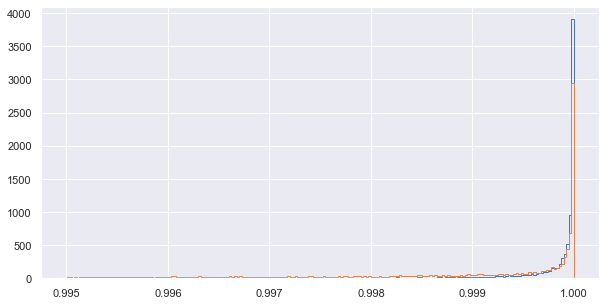

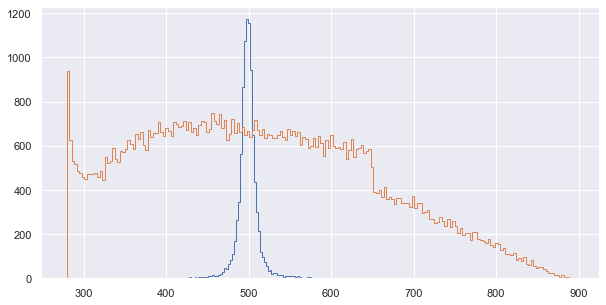

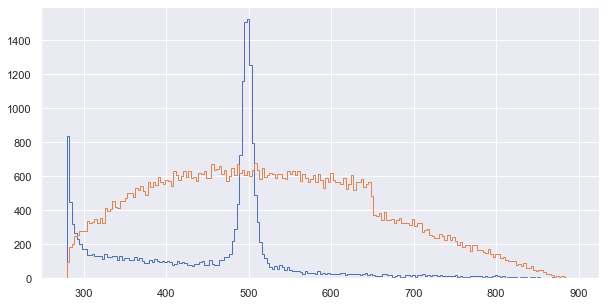

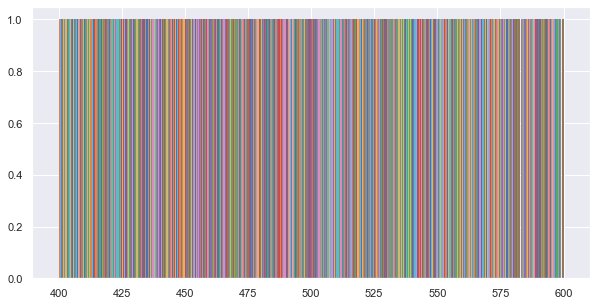

In [6]:
cosmask = dat["cosTheta"]>0.995

# plt.hist(dat["v0_ks_mass"][mask],100)
plt.show()
# plt.hist(dat["cosTheta"][mask],100)

t,f = tf(dat["cosTheta"][cosmask])
hists([t,f],200)

t,f = tf(dat["v0_ks_mass"])
hists([t,f],200)

t,f = dat["v0_ks_mass"][cosmask],dat["v0_ks_mass"][~cosmask]
hists([t,f],200)

massk = np.logical_and(dat["v0_ks_mass"]>400,dat["v0_ks_mass"]<600)

msk = np.logical_and(cosmask,massk)
t,f = dat["v0_ks_mass"][msk],dat["v0_ks_mass"][~msk]
hists(t,200)

In [26]:
param = [x for i,x in enumerate(shap) if i!="trueKs"]
X,Y = dat[param],dat[["trueKs"]]

X = preprocess(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
eval_s = [(X_train, y_train), (X_test, y_test)]

model = xgboost.XGBClassifier(learning_rate = 0.1,n_estimators = 300)
model.fit(X_train, y_train,verbose=5,eval_set=eval_s,early_stopping_rounds=15,eval_metric ="auc")
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
results = model.evals_result()

print("Accuracy: {:.3}".format(accuracy * 100.0))
print("AUC: {:.3}".format(np.max(results['validation_0']['auc'])))



C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_s

[0]	validation_0-auc:0.981169	validation_1-auc:0.980192
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[5]	validation_0-auc:0.987633	validation_1-auc:0.987236
[10]	validation_0-auc:0.990092	validation_1-auc:0.989973
[15]	validation_0-auc:0.990797	validation_1-auc:0.990714
[20]	validation_0-auc:0.991787	validation_1-auc:0.991729
[25]	validation_0-auc:0.992682	validation_1-auc:0.992537
[30]	validation_0-auc:0.993158	validation_1-auc:0.993027
[35]	validation_0-auc:0.993568	validation_1-auc:0.99343
[40]	validation_0-auc:0.993992	validation_1-auc:0.993822
[45]	validation_0-auc:0.995317	validation_1-auc:0.994991
[50]	validation_0-auc:0.995783	validation_1-auc:0.995531
[55]	validation_0-auc:0.996015	validation_1-auc:0.995763
[60]	validation_0-auc:0.996207	validation_1-auc:0.995948
[65]	validation_0-auc:0.996388	validation_1-auc:0.996129
[70]	validation_0-auc:0.996513	validation_1-auc:

C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 99.3


TypeError: can't multiply sequence by non-int of type 'float'

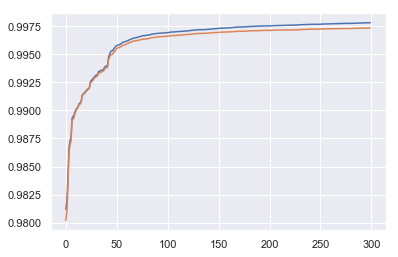

In [27]:
plt.plot(results['validation_0']['auc'], label='Train')
plt.plot(results['validation_1']['auc'], label='Train')
# plt.yscale("log")
plt.show()


Test on real data

In [32]:
y_pred = model.predict(truedat)

C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([1989093.,   10907.]),
 array([0. , 0.5, 1. ]),
 <a list of 2 Patch objects>)

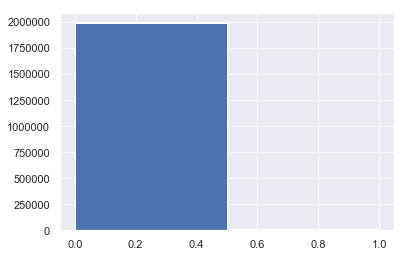

In [39]:
plt.hist(y_pred,2)

In [58]:
print(np.sum(dat["trueKs"])/len(dat["trueKs"]))
print(np.sum(y_pred)/len(y_pred))

0.0927765
1.0054535
